## Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import copy
import matplotlib
import pickle
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

In [4]:
from solowModel2 import SolowModel
from phase_diagram import PhaseDiagram

In [5]:
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':16})
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=16)

## Useful Functions

In [295]:
def heatmap(df, xlabel, ylabel, xvars, yvars, save=''):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(8,6)
    temp = ax.imshow(df.values, origin='lower')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.label_outer()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(3, 4))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(-4, -3))
    plt.xticks(range(df.shape[0]), df_criteria.columns, fontsize=12, rotation=45)
    plt.yticks(range(df.shape[1]), df_criteria.index, fontsize=12)
    ax.set_xticks(ax.get_xticks()[::5])
    ax.set_yticks(ax.get_yticks()[::5])
    ax.set_xticklabels(["{:.1e}".format(xvars[i]) for i in ax.get_xticks()])
    ax.set_yticklabels(["{:.1e}".format(yvars[i]) for i in ax.get_yticks()])
    fig.colorbar(temp)
    plt.tight_layout()
    if save is not '':
        plt.savefig(save, bbox_inches='tight')
    plt.show()

In [111]:
def sech(x):
    return 1/np.cosh(x)

# Exploration of the Dynamic Solow Model

#### General Case Setup

In [6]:
gamma = 1000
params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':2e-5, 'tau_y':1000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 2/gamma, "gamma":gamma,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

sm = SolowModel(params)

## Exploration of Long-term Sentiment Average

#### Functions


In [98]:
def sentiment_sol(s, b1):
    return np.arctanh(s) - b1*s

def kd_intersect(s, b2, gamma, c2, epsilon, rho):
    return b2*gamma*rho*c2*s + b2*gamma*epsilon

def case_kd(s, b1, b2, gamma, c2, epsilon, rho):
    # Capital Demand Case
    return np.abs(np.arctanh(s)-(b1*s) - (b2*gamma*rho*c2*s) - (b2*gamma*epsilon))

def case_kd_tanh(s, b1, b2, gamma, c2, epsilon, rho):
    # Capital Demand Case
    return np.abs(np.arctanh(s)-(b1*s) - np.tanh((b2*gamma*rho*c2*s) - (b2*gamma*epsilon)))

def case_ks(s, b1, b2, gamma, c2, epsilon):
    # Capital Supply Case
    return np.abs(np.arctanh(s)-(b1*s) - (b2*gamma*c2*s) - (b2*gamma*epsilon))

In [99]:
def zeros(func, params):
    """Determine the intersections"""
    intersects =[]
    # Search through four quadrants
    quads = [(-0.99,-0.5),(-0.5,0),(0,0.5),(0.5,0.99)]
    for bnds in quads:
        temp = minimize(func, 0.5*sum(bnds), args=params, bounds=(bnds,), tol=1e-15)
        intersects.append(temp.x[0])
    return [max(intersects), min(intersects)]

In [100]:
def approximation(s_bar, b1):
    constant = 0.5 * sum(s_bar)
    product = 0.5*sech(b1*s_bar[0]) + 0.5*sech(b1*s_bar[1])
    return [constant, product]

#### Proof of Correct Implementation


[0.6552746235030877, -0.5617113639958697]


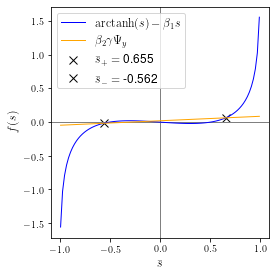

In [214]:
# Test for Correct implementation
gamma = 2000
b1, b2 = 1.1, 1.0
epsilon = 1e-5
c2 = 1e-4
rho=1/3

plt.rc('text', usetex=True)

x = np.linspace(-0.99, 0.99, 101)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(4,4)

ax.set_xlabel(r'$\bar{s}$')
ax.set_ylabel(r'$f(s)$')

ax.axhline(0, color='Gray')
ax.axvline(0, color='Gray')

ax.plot(x, f(x, 1.1), label=r'$\textrm{arctanh}(s)-\beta_1s$', color='Blue')
ax.plot(x, kd_intersect(x, b2, gamma, c2, epsilon, rho), label=r'$\beta_2\gamma\Psi_y$', color ='Orange')

sbar_x = zeros(case_kd, params=(b1, b2, gamma, c2, epsilon, rho))
print(sbar_x)
sbar_y = [np.arctanh(x)-1.1*x for x in sbar_x]

ax.scatter(sbar_x[0], sbar_y[0], marker='x', color='Black', label=r'$\bar{s}_+=$'+' {:.3f}'.format(sbar_x[0]))
ax.scatter(sbar_x[1], sbar_y[1], marker='x', color='Black', label=r'$\bar{s}_-=$'+' {:.3f}'.format(sbar_x[1]))

ax.legend()
plt.tight_layout()
plt.savefig('appendix2/example_solutions.png')
plt.show()
plt.rc('text', usetex=False)

#### Calculate Solutions

##### Verbose Solution

In [125]:
# Setup
g_vars = np.logspace(3,4,101)
c2_vars = np.logspace(-4,-3,101)

sbar_neg = np.empty((len(g_vars), len(c2_vars)))
sbar_pos = np.empty((len(g_vars), len(c2_vars)))

cons = np.empty((len(g_vars), len(c2_vars)))
mult = np.empty((len(g_vars), len(c2_vars)))

grow_kd = np.empty((len(g_vars), len(c2_vars)))
grow_ks = np.empty((len(g_vars), len(c2_vars)))

In [128]:
# Calculate Sentiment Equilibria
for i, gamma in enumerate(g_vars):
    for j, c2 in enumerate(c2_vars):
        sbar_neg[i,j], sbar_pos[i,j] = zeros(case_kd, params=(params['beta1'], params['beta2'], gamma, c2, params['epsilon'], params['rho']))
sbar = 0.5 * (sbar_pos + sbar_neg)

In [218]:
# Calculate the constant and multiplier for the expansion
for i, gamma in enumerate(g_vars):
    for j, c2 in enumerate(c2_vars): 
        cons[i,j] = 0.5*(np.tanh(params['beta1']*sbar_pos[i,j])+np.tanh(params['beta1']*sbar_neg[i,j]))
        mult[i,j] = 0.5*((sech(params['beta1']*sbar_pos[i,j])**2)+(sech(params['beta1']*sbar_neg[i,j])**2))

In [219]:
# Capital supply and demand growth rates
for i, gamma in enumerate(g_vars):
    for j, c2 in enumerate(c2_vars):     
        temp = mult[i,j]*params['beta2']*c2*gamma
        denom = 1 - params['rho']*temp
        
        grow_ks[i,j] = (params['epsilon'] + params['rho']*c2*cons[i,j]) / denom
        grow_kd[i,j] = c2*cons[i,j] + temp*grow_ks[i,j]

##### Functional Solution

In [287]:
def analysis(params, g_vars=np.linspace(1e3,1e4,101), c2_vars=np.linspace(1e-4,1e-3,101)):

    sbar_neg = np.empty((len(g_vars), len(c2_vars)))
    sbar_pos = np.empty((len(g_vars), len(c2_vars)))
    cons = np.empty((len(g_vars), len(c2_vars)))
    mult = np.empty((len(g_vars), len(c2_vars)))
    grow_kd = np.empty((len(g_vars), len(c2_vars)))
    grow_ks = np.empty((len(g_vars), len(c2_vars)))
    
    # Calculate Sentiment Equilibria
    for i, gamma in enumerate(g_vars):
        for j, c2 in enumerate(c2_vars):
            sbar_neg[i,j], sbar_pos[i,j] = zeros(case_kd, params=(params['beta1'], params['beta2'], gamma, c2, params['epsilon'], params['rho']))
            
            # Constant and multiplier
            cons[i,j] = 0.5*(np.tanh(params['beta1']*sbar_pos[i,j])+np.tanh(params['beta1']*sbar_neg[i,j]))
            mult[i,j] = 0.5*((sech(params['beta1']*sbar_pos[i,j])**2)+(sech(params['beta1']*sbar_neg[i,j])**2))
            
            # Growth Rates
            temp = mult[i,j]*params['beta2']*c2*gamma
            denom = 1 - params['rho']*temp
            grow_ks[i,j] = (params['epsilon'] + params['rho']*c2*cons[i,j]) / denom
            grow_kd[i,j] = c2*cons[i,j] + temp*grow_ks[i,j]
    return sbar_neg, sbar_pos, cons, mult, grow_kd, grow_ks

In [288]:
# Parameters
params = {
    'tech0': np.exp(1), 'rho':1/3, 'epsilon':1e-5, 'tau_y':1000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 2/1000, "gamma":1000,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

In [289]:
sbar_neg, sbar_pos, cons, mult, grow_kd, grow_ks = analysis(params)

In [291]:
# Mask to filter for positive 
mask_grow = pd.DataFrame(grow_ks<0)

# Mask => b2*gamma*psi_Y<<1
g_psiy = np.empty((len(g_vars), len(c2_vars)))
for i, gamma in enumerate(g_vars):
    g_psiy[i,:] = grow_ks[i,:] * gamma * params['beta2']
mask_smallpsiy = pd.DataFrame(g_psiy > 0.1)

mask = mask_smallpsiy.mask(mask_grow)

#### Long-term Average Sentiment

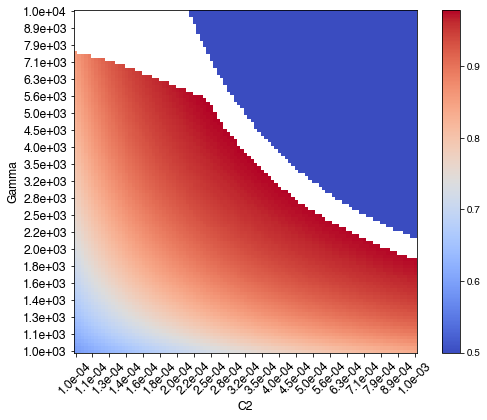

In [300]:
heatmap(pd.DataFrame(sbar_neg).mask(mask_smallpsiy),"C2", "Gamma", c2_vars, g_vars, save='appendix2/fig_sbar_negative.png')

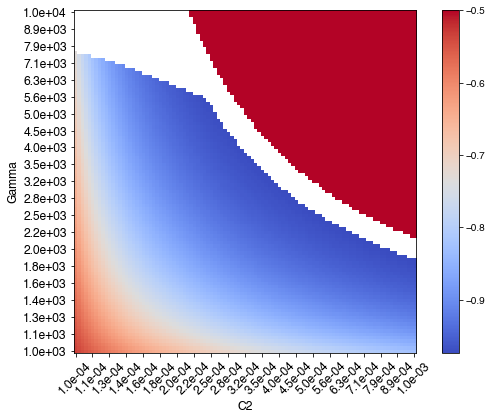

In [298]:
heatmap(pd.DataFrame(sbar_pos).mask(mask_smallpsiy),"C2", "Gamma", c2_vars, g_vars, save='appendix2/fig_sbar_positive.png')

#### Expansion Constant and Multiplier

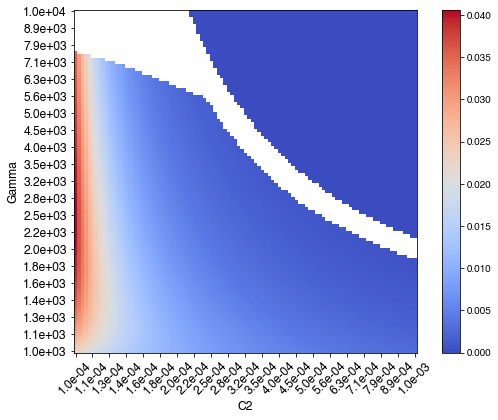

In [303]:
heatmap(pd.DataFrame(cons).mask(mask_smallpsiy),"C2", "Gamma", c2_vars, g_vars, save='appendix2/fig_constant_Q.png')

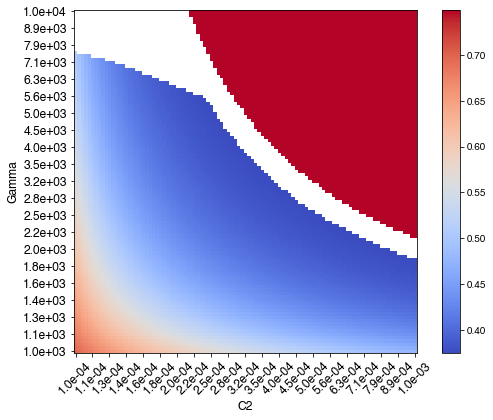

In [304]:
heatmap(pd.DataFrame(mult).mask(mask_smallpsiy),"C2", "Gamma", c2_vars, g_vars, save='appendix2/fig_constant_M.png')

#### Long-term Growth Rates

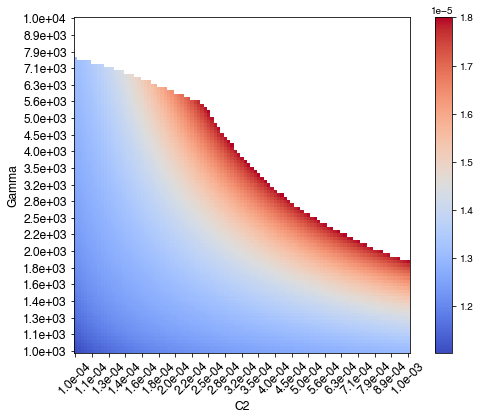

In [306]:
heatmap(pd.DataFrame(grow_ks).mask(mask_smallpsiy).mask(mask_grow),"C2", "Gamma", c2_vars, g_vars, save='appendix2/fig_psi_ks.png')

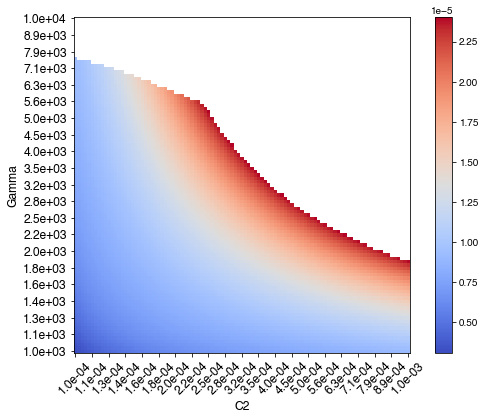

In [307]:
heatmap(pd.DataFrame(grow_kd).mask(mask_smallpsiy).mask(mask_grow),"C2", "Gamma", c2_vars, g_vars, save='appendix2/fig_psi_kd.png')

#### Convergence Line

In [372]:
# Convergence Line
df = pd.DataFrame(grow_ks-grow_kd).mask(mask_grow)
line = df.mask(df>1e-7).mask(df<-1e-7)
indices_array = np.nonzero(line.fillna(0).values)
indices = [(indices_array[0][i],indices_array[1][i]) for i in range(indices_array[0].shape[0])]

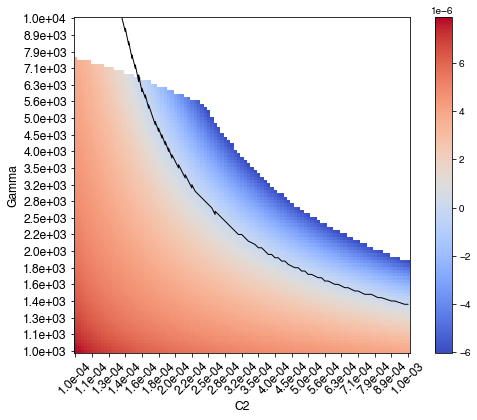

In [378]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)
temp = plt.imshow(df.mask(mask_smallpsiy).values, origin='lower')
plt.plot(indices_array[0], indices_array[1], color='Black')
plt.ylabel("Gamma")
plt.xlabel("C2")
ax.ticklabel_format(style='sci', axis='y', scilimits=(3, 4))
ax.ticklabel_format(style='sci', axis='x', scilimits=(-4, -3))
plt.xticks(range(df.shape[0]), df_criteria.columns, fontsize=12, rotation=45)
plt.yticks(range(df.shape[1]), df_criteria.index, fontsize=12)
ax.set_xticks(ax.get_xticks()[::5])
ax.set_yticks(ax.get_yticks()[::5])
ax.set_xticklabels(["{:.1e}".format(c2_vars[i]) for i in ax.get_xticks()])
ax.set_yticklabels(["{:.1e}".format(g_vars[i]) for i in ax.get_yticks()])
fig.colorbar(temp)
plt.tight_layout()
plt.savefig('appendix2/fig_psi_difference.png', bbox_inches='tight')
plt.show()

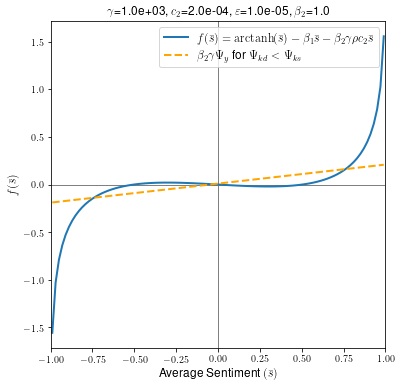

In [96]:
gamma = 1000
c2 = 2e-4
epsilon = 1e-5 
b2 = 1.0

plt.rc('text', usetex=True)
x = np.linspace(-0.99, 0.99, 101)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)

ax.axhline(0, color='gray')
ax.axvline(0, color='gray')

ax.plot(x, f(x, 1.1), linewidth=2, label=r'$f(\bar{s})=\textrm{arctanh}(\bar{s})-\beta_1\bar{s}-\beta_2\gamma\rho c_2\bar{s}$')
ax.plot(x, case_kd(x, b2, gamma, c2, epsilon), color='orange', linestyle='--', linewidth=2, label=r'$\beta_2\gamma\Psi_y$ for $\Psi_{kd}<\Psi_{ks}$')
#ax.axhline(case_ks(1, b2, gamma, c2, epsilon, 1/3), color='green', linestyle='--', linewidth=2, label=r'$\beta_2\gamma\Psi_y$ for $\Psi_{kd}>\Psi_{ks}$')

ax.set_xlim(-1,1)

ax.set_title(r'$\gamma$={:.1e}, $c_2$={:.1e}, $\varepsilon$={:.1e}, $\beta_2$={:.1f}'.format(gamma, c2, epsilon, b2))

ax.set_xlabel(r'Average Sentiment $(\bar{s})$')
ax.set_ylabel(r'$f(\bar{s})$')
ax.legend()
plt.show()

## Simulations for bounded and unbounded information

In [388]:
# kd=ks start
start = np.array([1, 10, 10, 0, 0, 1, params['saving0']])
# Accurate production adjustment
start[0] = params['epsilon'] + params['rho'] * min(start[1:3])

In [398]:
params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':1e-5, 'tau_y':1000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 3.2e-4, "gamma":2000,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

#### Seed 40

In [ ]:
sm_g_40 = SolowModel(params, xi_args=dict(decay=0.2, diffusion=2.0))
path = sm_g_40.solve(start, t_end=1e5, seed=40, case='general', save=True)
sm_g_40.overview(asymptotics=False)

In [ ]:
fig = plt.figure()
fig.set_size_inches(6,3)
plt.plot(sm_g_40.path.h)
plt.show()

In [ ]:
sm_ui_40 = SolowModel(params, xi_args=dict(decay=0.2, diffusion=2.0))
path = sm_ui_40.solve(start, t_end=1e5, seed=40, case='unbounded_information', save=True)
sm_ui_40.overview(asymptotics=False)

In [ ]:
fig = plt.figure()
fig.set_size_inches(6,3)
plt.plot(sm_ui_40.path.h)
plt.show()

#### Seed 50

In [ ]:
sm_g_50 = SolowModel(params, xi_args=dict(decay=0.2, diffusion=2.0))
path = sm_g_50.solve(start, t_end=1e5, seed=50, case='general', save=True)
sm_g_50.overview(asymptotics=False)

In [ ]:
fig = plt.figure()
fig.set_size_inches(6,3)
plt.plot(sm_g_50.path.h)
plt.show()

In [ ]:
sm_ui_50 = SolowModel(params, xi_args=dict(decay=0.2, diffusion=2.0))
path = sm_ui_50.solve(start, t_end=1e5, seed=50, case='unbounded_information', save=True)
sm_ui_50.overview(asymptotics=False)

In [ ]:
fig = plt.figure()
fig.set_size_inches(6,3)
plt.plot(sm_ui_50.path.h)
plt.show()

## Empirical Data For Parameters

### Savings Rate
Taking the macro approach => savings rate is roughly equal to the gdp divided by the real investment

In [43]:
gdp = pd.read_csv('GDPC1.csv')
gdp.set_index('DATE', inplace=True)
df = pd.DataFrame(gdp)
df.columns = ['gdp']

investment = pd.read_csv('GPDIC1.csv')
investment.set_index('DATE', inplace=True)
df.loc[:,'investment'] = investment
df.loc[:,'saving'] = df.investment / df.gdp

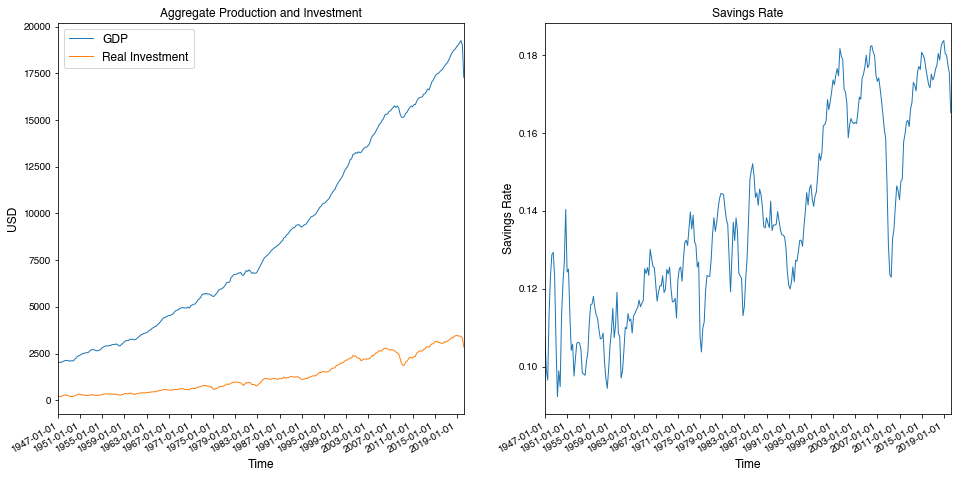

In [94]:
import matplotlib.dates as mdates
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16,8)

ax[0].plot(df.gdp, label='GDP')
ax[0].plot(df.investment, label='Real Investment')
ax[0].set_title('Aggregate Production and Investment')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('USD')
ax[0].legend()
ax[0].set_xlim(df.index[0], df.index[-1])
ax[0].set_xticks(ax[0].get_xticks()[::16])

ax[1].plot(df.saving, label='Savings Rate')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Savings Rate')
ax[1].set_title('Savings Rate')
ax[1].set_xticks(ax[1].get_xticks()[::16])
ax[1].set_xlim(df.index[0], df.index[-1])
fig.autofmt_xdate()
plt.show()